In [25]:
from obspy.clients.fdsn import Client
import datetime
import pandas as pd
import pygmt
import tempfile


In [37]:
import datetime
import pandas as pd
from obspy.clients.fdsn import Client

# Initialize the FDSN client
client_inventory = Client('IRIS')

year1 = 2010

# Now create your list of days to loop over!
time1 = datetime.datetime(year=year1, month=1, day=1)
time2 = datetime.datetime(year=year1 + 6, month=1, day=1)

# Example usage of client_inventory to get stations
inventory = client_inventory.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                          minlatitude=40, minlongitude=-129, maxlatitude=50, maxlongitude=-123,
                                          starttime=time1.strftime('%Y-%m-%d'), endtime=time2.strftime('%Y-%m-%d'))

# Initialize a list to store station data
stations_data = []

# Iterate through the inventory to extract station details
for network in inventory:
    for station in network:
        start_date = station.start_date.datetime
        end_date = station.end_date.datetime if station.end_date else datetime.datetime.now()
        active_days = (end_date - start_date).days
        stations_data.append({
            'station': f"{network.code}.{station.code}.",
            'latitude': station.latitude,
            'longitude': station.longitude,
            'elevation': station.elevation,
            'active_days': active_days
        })

# Create a dataframe
stations_df = pd.DataFrame(stations_data)

# Print the dataframe to verify
print(stations_df)

       station   latitude   longitude  elevation  active_days
0      7A.W01.  48.079700 -126.342499    -1697.0          346
1      7A.W02.  48.259300 -126.496803    -2133.0          347
2      7A.W03.  48.387501 -126.728699    -2489.0          347
3      7A.W04.  48.531700 -126.890800    -2319.0          348
4      7A.W05.  48.667500 -127.013397    -2011.0          348
..         ...        ...         ...        ...          ...
589  Z5.GS270.  40.785599 -125.556801    -3041.0          283
590  Z5.GS280.  41.033600 -126.093399    -3125.0          275
591  Z5.GS300.  40.786400 -126.468201    -3151.0          292
592  Z5.GS311.  40.455399 -125.132004    -2498.0          409
593  Z5.GS400.  40.141602 -127.822998    -4510.0          291

[594 rows x 5 columns]


In [38]:
nan_exists = stations_df.isna().any().any()
print(f"Are there any NaN values in the dataframe? {nan_exists}")

Are there any NaN values in the dataframe? False


In [39]:
stations_df.to_csv('../data/datasets_all_regions/all_stations_for_picking.csv', index=False)

In [30]:
# Initialize lists to store ocean bottom and land stations
obs = []
land_stations = []

# Iterate through the inventory to classify stations
for network in inventory:
    for station in network:
        station_code = f"{network.code}.{station.code}."
        if station_code in stations_df['station'].values:
            if station.site.name and 'OBS' in station.site.name:
                obs.append(station_code)
            else:
                land_stations.append(station_code)

# Create dataframes for ocean bottom and land stations
obs_df = stations_df[stations_df['station'].isin(obs)]
land_stations_df = stations_df[stations_df['station'].isin(land_stations)]

# Print the dataframes to verify
print("Ocean Bottom Stations:")
print(obs_df)
print("\nLand Stations:")
print(land_stations_df)

Ocean Bottom Stations:
       station   latitude   longitude  elevation  active_days
0      7A.W01.  48.079700 -126.342499    -1697.0          346
1      7A.W02.  48.259300 -126.496803    -2133.0          347
2      7A.W03.  48.387501 -126.728699    -2489.0          347
3      7A.W04.  48.531700 -126.890800    -2319.0          348
4      7A.W05.  48.667500 -127.013397    -2011.0          348
..         ...        ...         ...        ...          ...
589  Z5.GS270.  40.785599 -125.556801    -3041.0          283
590  Z5.GS280.  41.033600 -126.093399    -3125.0          275
591  Z5.GS300.  40.786400 -126.468201    -3151.0          292
592  Z5.GS311.  40.455399 -125.132004    -2498.0          409
593  Z5.GS400.  40.141602 -127.822998    -4510.0          291

[415 rows x 5 columns]

Land Stations:
      station   latitude   longitude  elevation  active_days
249   BK.JCC.  40.817451 -124.029549       27.2         8663
250  C8.BPCB.  48.923600 -123.704500       31.0         2274
251  C8.MW

plot [WARNING]: Mismatch between actual (1) and expected (2) fields near line 1684 in file PB2002_boundaries.dig
plot [WARNING]: Mismatch between actual (1) and expected (2) fields near line 5086 in file PB2002_boundaries.dig
plot [WARNING]: Mismatch between actual (1) and expected (2) fields near line 5113 in file PB2002_boundaries.dig
plot [WARNING]: Your data array row 17 contains NaNs - no resampling taken place!
plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.
plot [WARNING]: Cannot use auto-legend -l for variable symbol color. Option -l ignored.


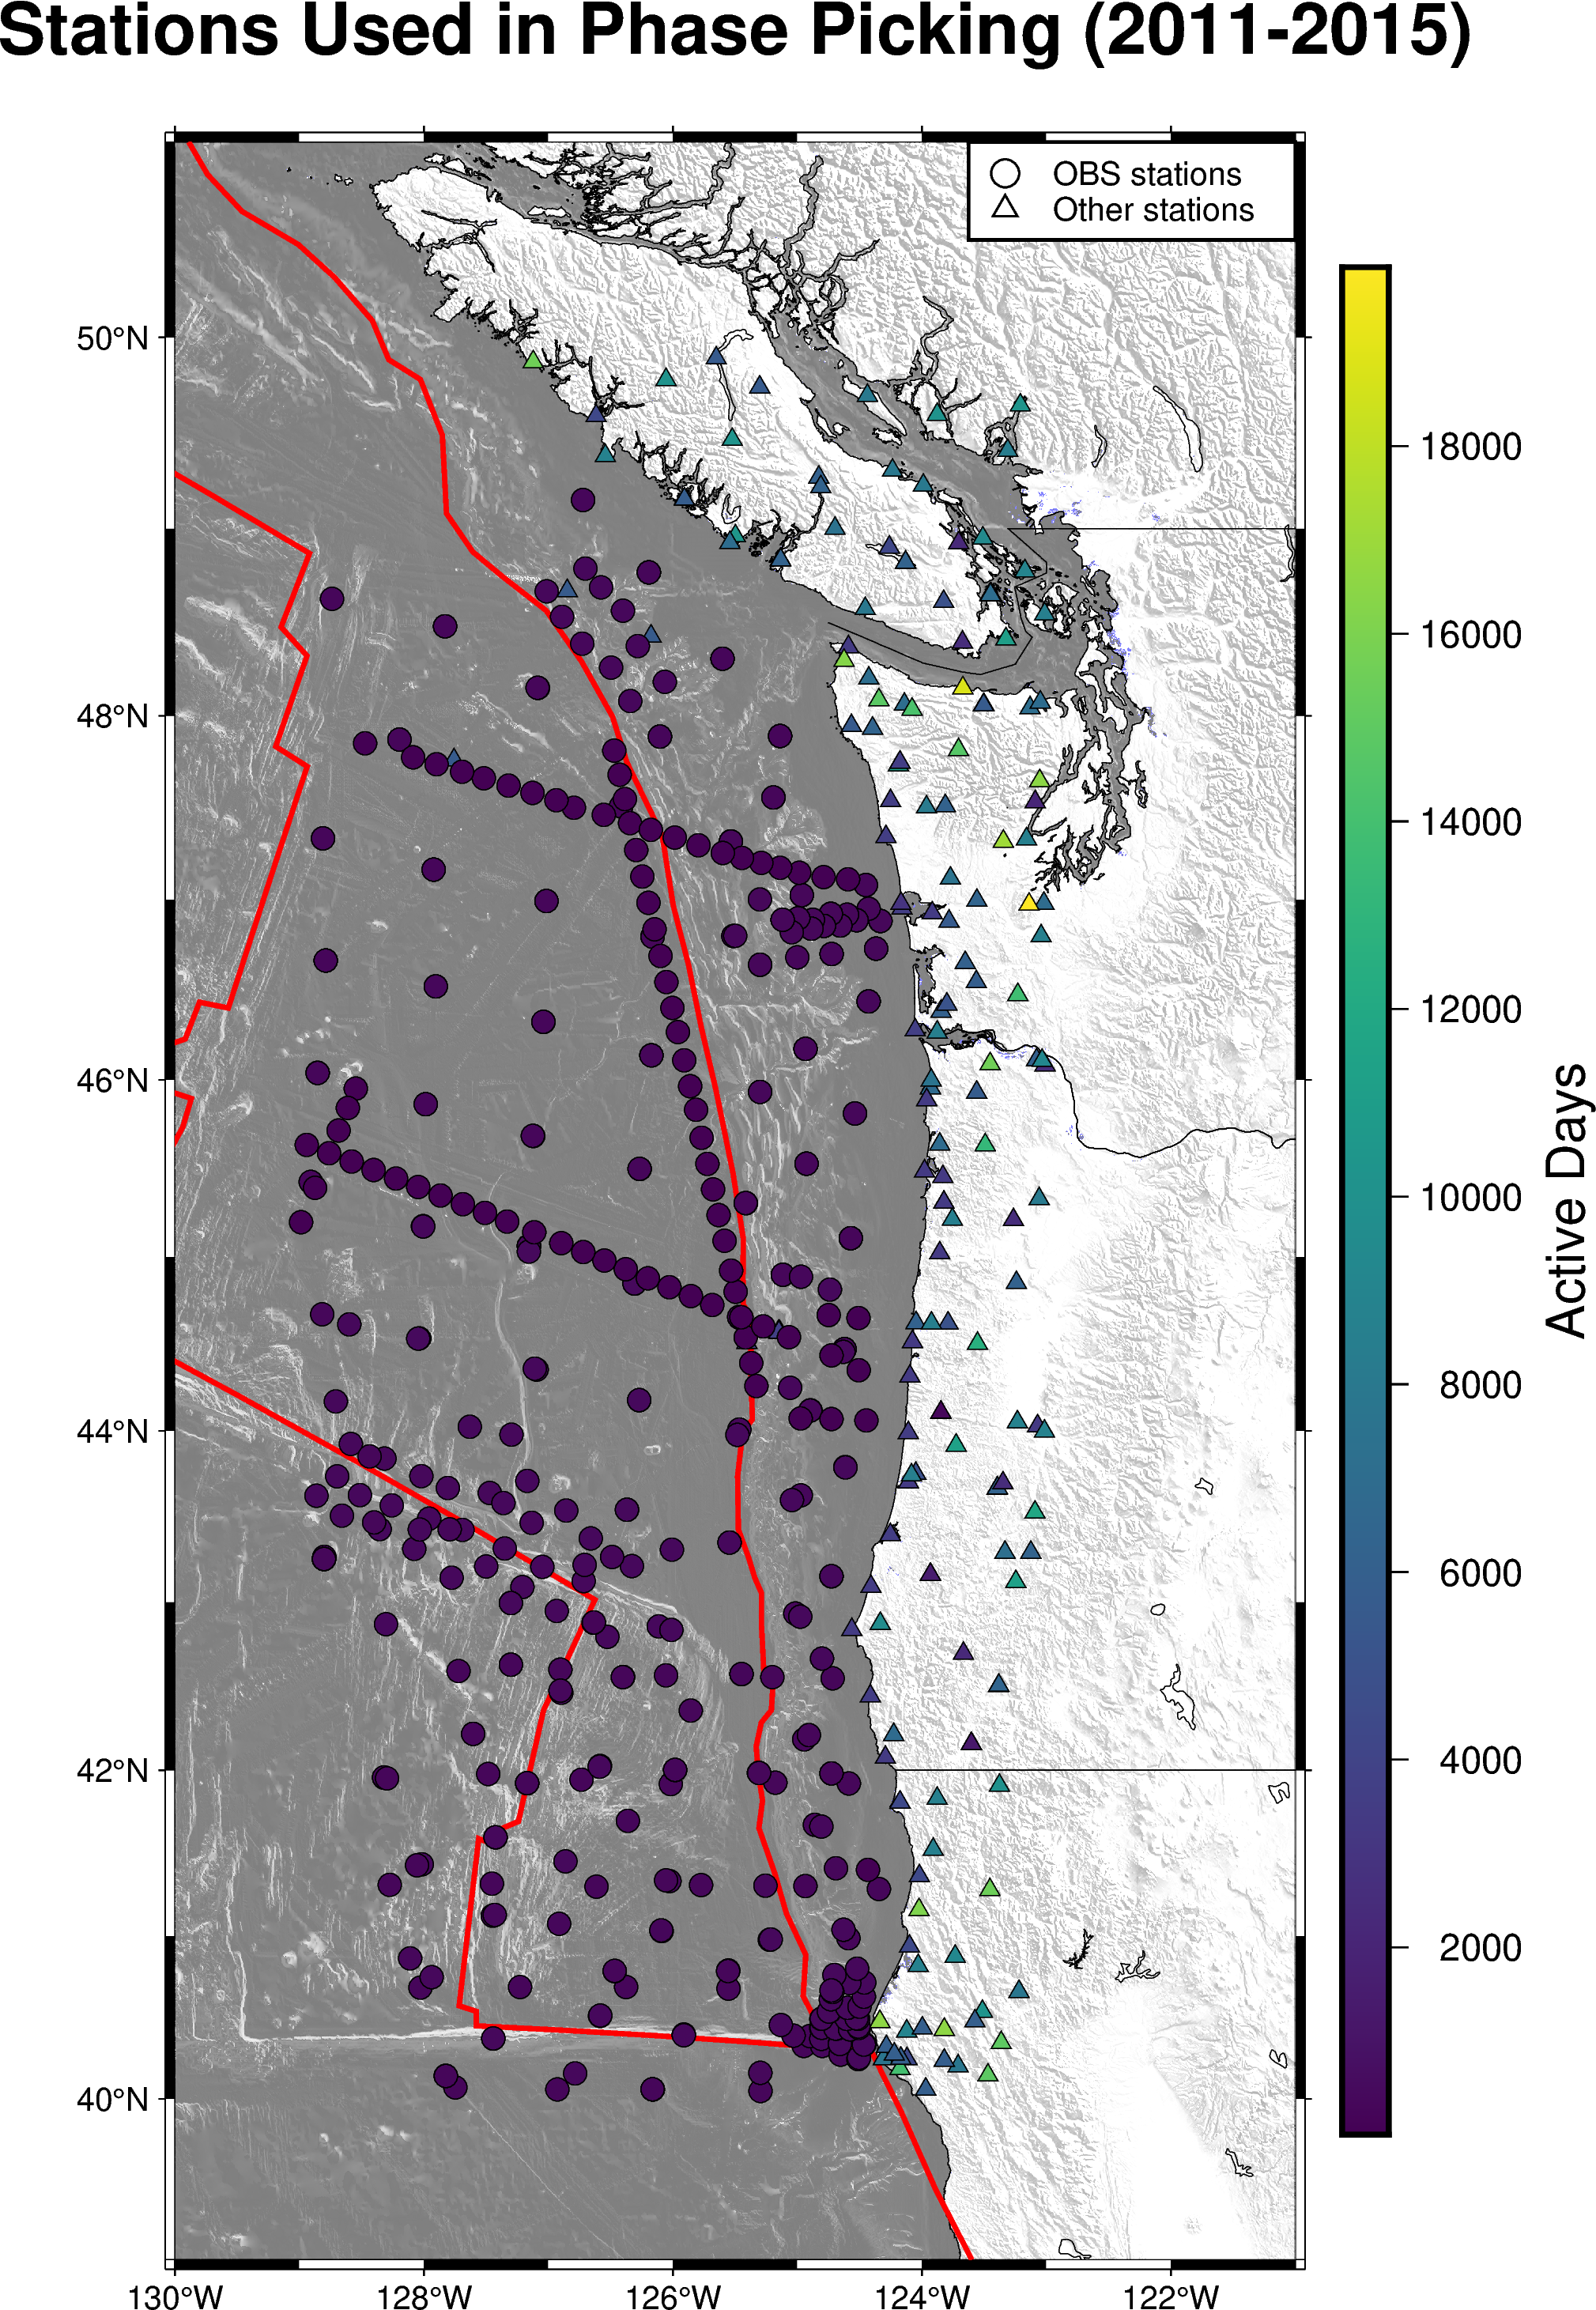

In [31]:
import pygmt
import pandas as pd

# # Sample data for stations DataFrame
# stations = pd.DataFrame({
#     'station': ['STA1', 'STA2', 'STA3', 'STA4'],
#     'latitude': [47.0, 48.0, 49.0, 50.0],
#     'longitude': [-122.0, -123.0, -124.0, -125.0],
#     'active_days': [10, 20, 30, 40]
# })

# Define target region
min_lat = 39
max_lat = 51
min_lon = -130
max_lon = -121

# Plotting parameters
transparency = 60

# Initialize the figure
fig = pygmt.Figure()

# Load grid data
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[min_lon, max_lon, min_lat, max_lat])
shade = pygmt.grdgradient(grid=grid, azimuth="0/90", normalize="t1")

# Define target region
region = [min_lon, max_lon, min_lat, max_lat]
title = "Stations Used in Phase Picking (2011-2015)"
fig.basemap(region=region, projection="M12c", frame=["af", f"WSne+t{title}"])

fig.grdimage(grid=grid, cmap="blue", shading=shade, transparency=50)
fig.coast(region=region, projection="M12c", shorelines=True, borders=[1, 2], resolution="f")

# Create a custom colormap based on the number of active days
pygmt.makecpt(cmap="viridis", series=[stations_df['active_days'].min(), stations_df['active_days'].max()])

# Add plate boundaries
fig.plot(data="PB2002_boundaries.dig", pen="1.5p,red")

# Plot stations with color coding based on the number of active days
fig.plot(
    x=land_stations_df['longitude'],
    y=land_stations_df['latitude'],
    style="t0.25c",  # Circle with size 0.5 cm
    fill=land_stations_df['active_days'],  # Use fill instead of color
    cmap=True,
    pen="black",
    label='Station'
)

fig.plot(
    x=obs_df['longitude'],
    y=obs_df['latitude'],
    style="c0.25c",  # Circle with size 0.5 cm
    fill=obs_df['active_days'],  # Use fill instead of color
    cmap=True,
    pen="black",
    label='Station'
)

legend_entries = """
S 0.25c c 0.3c white 0.6p 0.3i OBS stations
S 0.25c t 0.3c white 0.6p 0.3i Other stations
"""

# Write legend entries to a temporary file
with tempfile.NamedTemporaryFile(mode='w+', delete=False) as tmpfile:
    tmpfile.write(legend_entries)
    tmpfile_path = tmpfile.name
    
# Add a legend for the pick scale to the plot
fig.legend(spec=tmpfile_path,position="JTR+w3.5+jTR", box='+gwhite+p1p')

# Add a vertical color bar
fig.colorbar(position="JMR+o0.5c/0c+w20c/0.5c", frame=["a", "x+lActive Days"])# Save and display the figure
fig.savefig("stations_active_days.pdf")
fig.show()

In [40]:
import os

# Define the base directory for pick files
base_dir = "/home/hbito/cascadia_obs_ensemble_backup/data"

# Define the years to check
years = range(2010, 2016)

# Initialize a list to store stations with pick files
stations_with_picks = []

# Iterate through each station in the dataframe
for station in stations_df['station']:
    station_has_picks = False
    # Check each year directory for pick files
    for year in years:
        pick_dir = os.path.join(base_dir, f"picks_{year}")
        # Check if the directory exists
        if os.path.exists(pick_dir):
            # List all files in the directory
            pick_files = os.listdir(pick_dir)
            # Check if any file starts with the station code
            if any(pick_file.startswith(station.split('.')[1]) for pick_file in pick_files):
                station_has_picks = True
                break
    # If the station has pick files, add it to the list
    if station_has_picks:
        stations_with_picks.append(station)

# Write the stations with pick files to a text file
with open("../data/datasets_all_regions/stations_with_picks.txt", "w") as f:
    for station in stations_with_picks:
        f.write(f"{station}\n")

print("Stations with pick files have been listed in 'stations_with_picks.txt'.")
# Write all stations to a text file, excluding those with pick files
with open("../data/datasets_all_regions/stations_without_picks.txt", "w") as f:
    for station in stations_df['station']:
        if station not in stations_with_picks:
            f.write(f"{station}\n")

print("Stations without pick files have been listed in 'stations_without_picks.txt'.")

Stations with pick files have been listed in 'stations_with_picks.txt'.
Stations without pick files have been listed in 'stations_without_picks.txt'.


In [33]:
stations_df['station'][0].split('.')[0]

'7A'